In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [1]:
!kaggle datasets download -d justinas/nba-players-data

Dataset URL: https://www.kaggle.com/datasets/justinas/nba-players-data
License(s): other
  0% 0.00/564k [00:00<?, ?B/s]
100% 564k/564k [00:00<00:00, 108MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nba-players-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [7]:
# Load dataset
data = pd.read_csv("/content/all_seasons.csv")
data.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         12844 non-null  int64  
 1   player_name        12844 non-null  object 
 2   team_abbreviation  12844 non-null  object 
 3   age                12844 non-null  float64
 4   player_height      12844 non-null  float64
 5   player_weight      12844 non-null  float64
 6   college            10990 non-null  object 
 7   country            12844 non-null  object 
 8   draft_year         12844 non-null  object 
 9   draft_round        12844 non-null  object 
 10  draft_number       12844 non-null  object 
 11  gp                 12844 non-null  int64  
 12  pts                12844 non-null  float64
 13  reb                12844 non-null  float64
 14  ast                12844 non-null  float64
 15  net_rating         12844 non-null  float64
 16  oreb_pct           128

In [9]:
data.describe()

,Unnamed: 0,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
count,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000
mean,6421.500000,27.045313,200.555097,100.263279,51.154158,8.212582,3.558486,1.824681,-2.226339,0.054073,0.140646,0.184641,0.513138,0.131595
std,3707.887763,4.339211,9.111090,12.426628,25.084904,6.016573,2.477885,1.800840,12.665124,0.043335,0.062513,0.053545,0.101724,0.094172
min,0.000000,18.000000,160.020000,60.327736,1.000000,0.000000,0.000000,0.000000,-250.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3210.750000,24.000000,193.040000,90.718400,31.000000,3.600000,1.800000,0.600000,-6.400000,0.021000,0.096000,0.149000,0.482000,0.066000
50%,6421.500000,26.000000,200.660000,99.790240,57.000000,6.700000,3.000000,1.200000,-1.300000,0.040000,0.130500,0.181000,0.525000,0.103000
75%,9632.250000,30.000000,208.280000,108.862080,73.000000,11.500000,4.700000,2.400000,3.200000,0.083000,0.179000,0.217000,0.563000,0.179000
max,12843.000000,44.000000,231.140000,163.293120,85.000000,36.100000,16.300000,11.700000,300.000000,1.000000,1.000000,1.000000,1.500000,1.000000


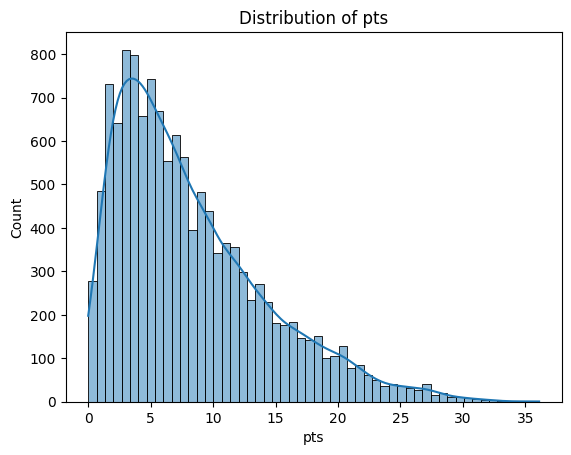

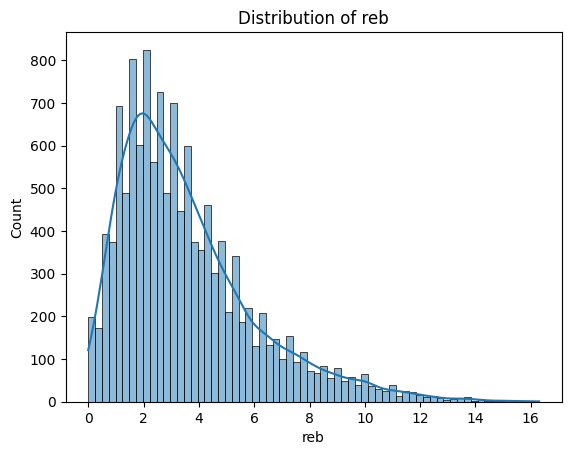

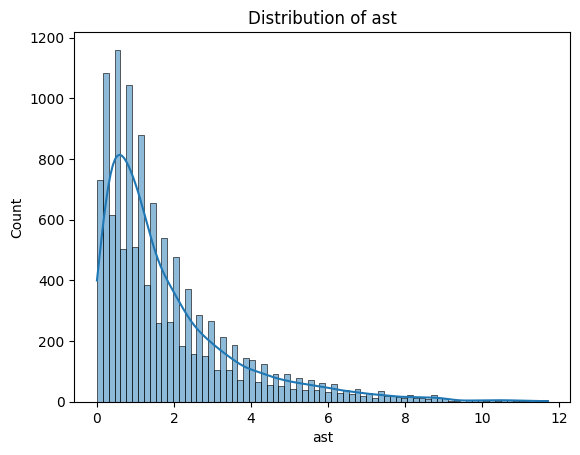

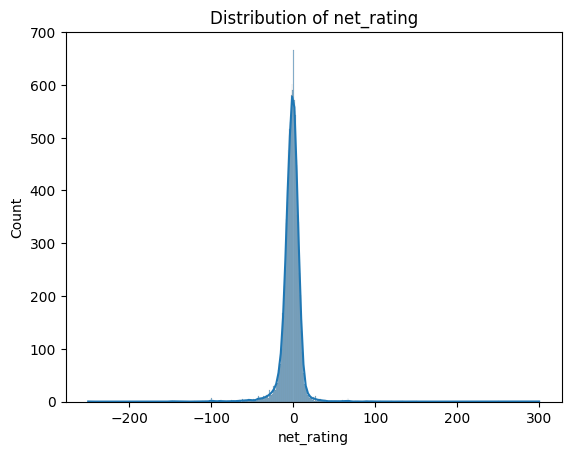

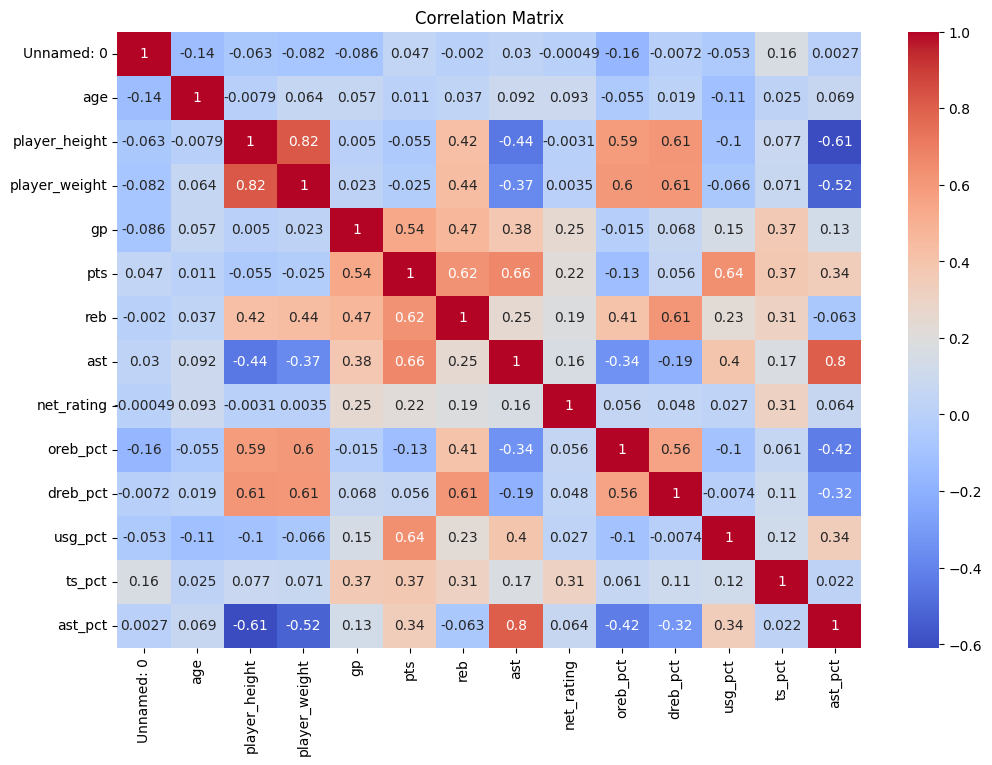

In [11]:
# Distribution of key statistics
stats = ['pts', 'reb', 'ast', 'net_rating']
for stat in stats:
    sns.histplot(data[stat], kde=True)
    plt.title(f"Distribution of {stat}")
    plt.show()

# Correlation analysis
# Select only numeric columns for correlation analysis
numeric_data = data.select_dtypes(include=np.number)
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [13]:
# Select features correlated with points (example target)
target = 'pts'  # Replace with your chosen target variable
correlated_features = corr_matrix[target].abs().sort_values(ascending=False)
print("Features correlated with target:\n", correlated_features)

Features correlated with target:
 pts              1.000000
ast              0.664320
usg_pct          0.641469
reb              0.624509
gp               0.536003
ts_pct           0.373439
ast_pct          0.337339
net_rating       0.215199
oreb_pct         0.125164
dreb_pct         0.055669
player_height    0.055284
Unnamed: 0       0.047024
player_weight    0.025023
age              0.011353
Name: pts, dtype: float64


In [14]:
# Features and target variable
X = data[['age', 'player_height', 'player_weight', 'gp', 'ast', 'reb']]  # Example features
y = data['pts']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Ridge Regression
ridge = Ridge(alpha=1.0)  # Adjust alpha for regularization strength
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Model evaluation
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))

print("Ridge Regression R^2:", r2_score(y_test, y_pred_ridge))
print("Ridge Regression MAE:", mean_absolute_error(y_test, y_pred_ridge))

Linear Regression R^2: 0.6910745043170945
Linear Regression MAE: 2.3897246969913897
Ridge Regression R^2: 0.691074070545727
Ridge Regression MAE: 2.3897411988072297


In [16]:
# Feature importance (coefficients)
feature_names = X.columns
lr_coefficients = lr.coef_
ridge_coefficients = ridge.coef_

# Combine feature importance into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Linear Regression': lr_coefficients,
    'Ridge Regression': ridge_coefficients
})
print(importance_df)


         Feature  Linear Regression  Ridge Regression
0            age          -0.329010         -0.328965
1  player_height           0.043568          0.043428
2  player_weight          -0.330618         -0.330454
3             gp           0.824215          0.824371
4            ast           2.913455          2.913179
5            reb           2.780853          2.780562
